This notebook has been designed for the nurse care challenge competition with the the aim of providing the basic knowledge of Human Activity Recognition and forecasting.

It has been made by Nazmun Nahid.

# Exploring the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

**First, we have to load the data. In this tutorial, we only use the train data of a single user to make the process simple.**

In [ ]:
#Load data
df1=pd.read_csv('/content/drive/MyDrive/ABC2022/InternalChallenge/Tutorial /acc_user7.csv')
df2=pd.read_csv('/content/drive/MyDrive/ABC2022/InternalChallenge/Tutorial /user7.csv')

**Let's check what information the data contains.**

In [ ]:
df1.head(5)

,subject_id,datetime,x,y,z
0,7,2018-06-01T21:45:35.905+0900,-0.229,-0.114,9.804
1,7,2018-06-01T22:54:07.513+0900,-0.229,-0.114,9.804
2,7,2018-06-01T20:55:13.321+0900,-0.229,-0.114,9.805
3,7,2018-06-11T19:13:43.424+0900,-0.229,-0.114,9.806
4,7,2018-06-08T19:13:31.783+0900,-0.229,-0.114,9.804


We can see that the data file contains 5 columns: subject_id, datetime, and 3 coordinates of the accelerometer data.

In [ ]:
df2.head(5)

,id,user_id,activity_type_id,activity_type,target_id,activity2user_id,start,finish
0,37981,7,4,排泄,31,96178,NaN,NaN
1,34410,7,4,排泄,35,89262,NaN,NaN
2,15380,7,4,排泄,38,50826,NaN,2018-05-12 06:32:42 +0900
3,37812,7,4,排泄,40,95859,NaN,2018-06-19 02:37:41 +0900
4,34025,7,4,排泄,44,88134,NaN,2018-06-12 21:03:05 +0900


We can see that the data file 8 columns: id (label id), user_id, activity_type_id, activity_type (name), target_id (patients), activity2user_id, start and finish timestamp of the activity.


In [ ]:
df1.shape # to check the row column info

(19592919, 5)

In [ ]:
df2.shape # to check the row column info

(3851, 8)

In [ ]:
df1.isnull().sum()# to check the missing value info

subject_id    0
datetime      0
x             0
y             0
z             0
dtype: int64

In [ ]:
df2.isnull().sum()# to check the missing info

id                   0
user_id              0
activity_type_id     0
activity_type        0
target_id            0
activity2user_id     0
start               43
finish              55
dtype: int64

**Visualization of the data**

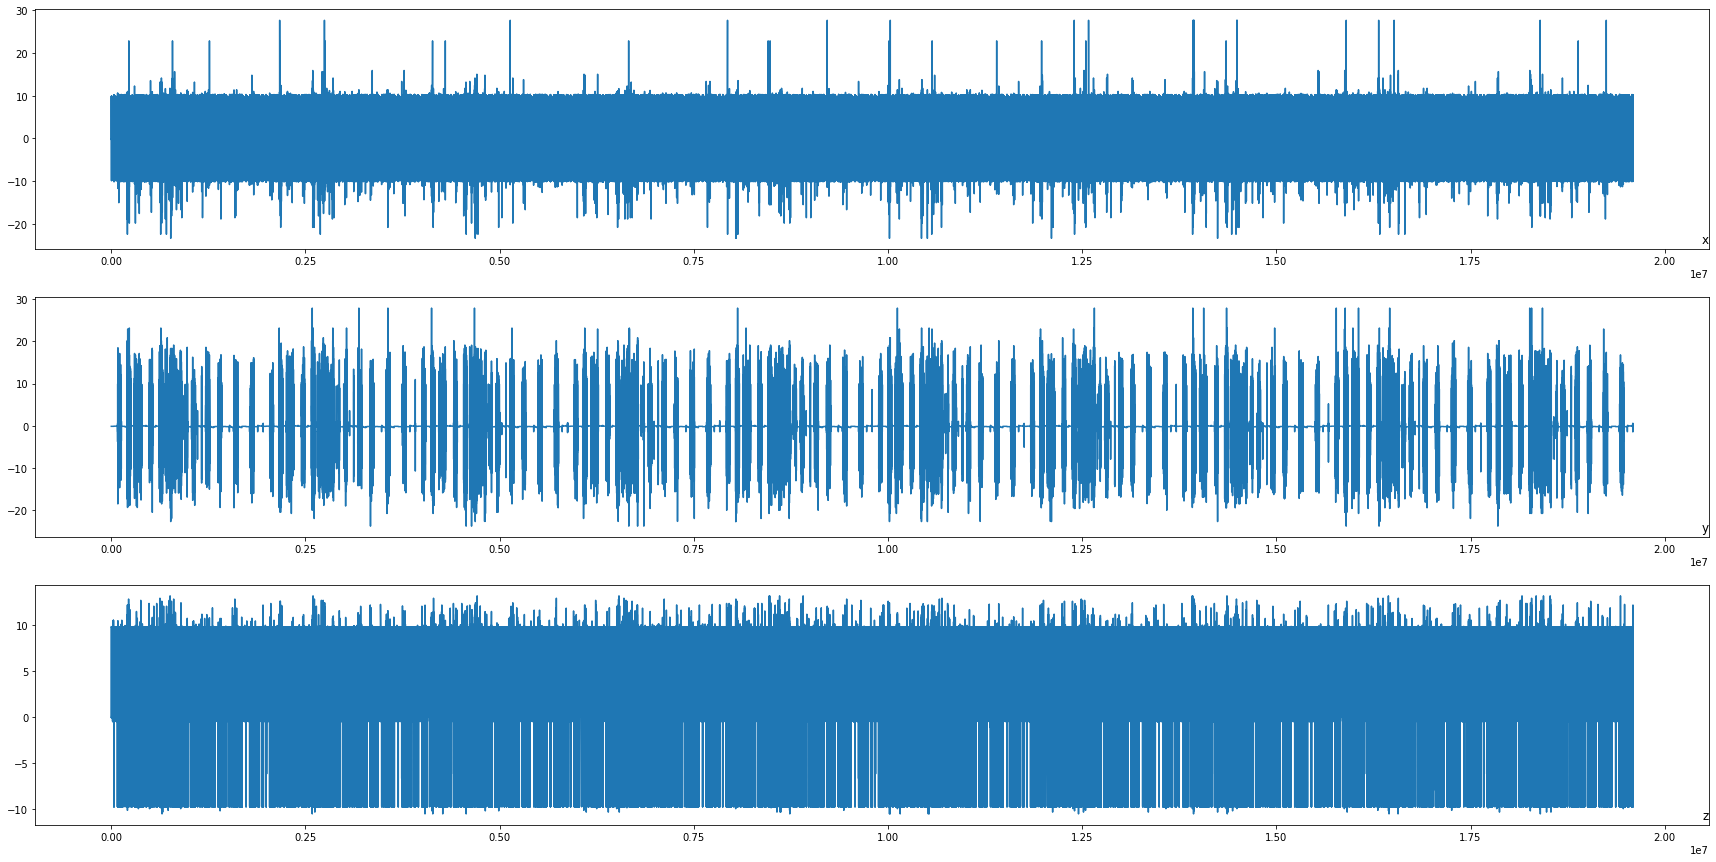

In [ ]:
from pandas import read_csv
from matplotlib import pyplot

values1 = df1.values
groups = [2,3,4]
i = 1
# plot each column
pyplot.figure(figsize=(30,15))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values1[:, group])
	pyplot.title(df1.columns[group], y=0, loc='right')
	i += 1
pyplot.show()

Here we can see the signals of the three axis of the accelerometer data separately.

Now let’s check the quantity of each activity type.

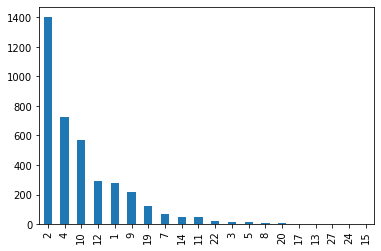

In [ ]:
df2['activity_type_id'].value_counts().plot.bar()


# Hourly Based Activity Forecasting Using Accelerometer Data



## Preprocessing

In [ ]:
import datetime

**We are going to put the data frames to different data frames for ease of use. It is not mandatory to do so**

In [ ]:
user_df = df1
act_df = df2

In [ ]:
user_df.head()

,subject_id,datetime,x,y,z
0,7,2018-06-01T21:45:35.905+0900,-0.229,-0.114,9.804
1,7,2018-06-01T22:54:07.513+0900,-0.229,-0.114,9.804
2,7,2018-06-01T20:55:13.321+0900,-0.229,-0.114,9.805
3,7,2018-06-11T19:13:43.424+0900,-0.229,-0.114,9.806
4,7,2018-06-08T19:13:31.783+0900,-0.229,-0.114,9.804


In [ ]:
user_df = user_df.dropna() # to drop the nan values
user_df = user_df.sort_values('datetime') # While doing time series analysis it is very important to sort the file according to time stamp
user_df = user_df.drop_duplicates() # to drop duplicate columns

In [ ]:
act_df = act_df.drop_duplicates('id') # to drop duplicate columns
act_df = act_df.dropna()# to drop the nan values

**Now we need to format the time stamp**

In [ ]:
user_df['datetime']= pd.to_datetime(user_df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f%z')
act_df['start'] = pd.to_datetime(act_df['start'], format='%Y-%m-%d %H:%M:%S %z')
act_df['finish'] = pd.to_datetime(act_df['finish'], format='%Y-%m-%d %H:%M:%S %z')

In [ ]:
user_df.head()

,subject_id,datetime,x,y,z
3395643,7,2018-04-06 14:38:36.798000+09:00,-9.768,-0.229,0.002
5831965,7,2018-04-06 14:38:36.999000+09:00,-9.921,-0.038,0.003
3871746,7,2018-04-06 14:38:37.036000+09:00,-9.921,-0.038,0.003
5836538,7,2018-04-06 14:38:37.198000+09:00,-9.845,-0.038,0.004
14154615,7,2018-04-06 14:38:37.398000+09:00,-9.807,-0.038,0.004


In [ ]:
act_df.head()

,id,user_id,activity_type_id,activity_type,target_id,activity2user_id,start,finish
5,4292,7,4,排泄,29,25732,2018-04-13 08:27:45+09:00,2018-04-13 08:27:45+09:00
6,9859,7,4,排泄,38,40119,2018-05-02 09:19:58+09:00,2018-05-02 09:20:24+09:00
7,10021,7,4,排泄,43,40442,2018-05-02 12:53:05+09:00,2018-05-02 12:53:06+09:00
8,10590,7,4,排泄,35,41716,2018-05-03 12:49:54+09:00,2018-05-03 12:51:03+09:00
9,10592,7,4,排泄,36,41718,2018-05-03 12:51:11+09:00,2018-05-03 12:51:25+09:00


In [ ]:
act_df['year-month-date'] = act_df['start'].dt.date.astype(str)
act_df['hour'] = act_df['start'].dt.hour
act_df['year-month-date-hour'] = act_df['year-month-date'].astype(str) + '-' +act_df['hour'].astype(str).str.zfill(2)

act_df = act_df.sort_values('start')
act_labels = list(act_df['activity_type_id'].value_counts().index)
users = list(act_df['user_id'].value_counts().index)

In [ ]:
user_df['datetime'].dt.hour.value_counts().sort_index()

0      83094
1      89260
2      89659
3      83127
4      74140
5      66761
6      60827
7      97326
8     118212
9      54020
10     60726
11     84794
12     72488
13     89470
14     86122
15     74377
16     77137
17    107071
18    142372
19    126676
20    100781
21    108547
22    113514
23    115887
Name: datetime, dtype: int64

In [ ]:
display(act_df.head())
print(act_labels)

,id,user_id,activity_type_id,activity_type,target_id,activity2user_id,start,finish,year-month-date,hour,year-month-date-hour
750,2820,7,1,バイタル,30,21836,2018-03-14 14:37:40+09:00,2018-03-14 14:40:19+09:00,2018-03-14,14,2018-03-14-14
1144,3082,7,2,食事・服薬,29,22526,2018-03-16 07:39:38+09:00,2018-03-15 10:00:37+09:00,2018-03-16,7,2018-03-16-07
1153,4000,7,2,食事・服薬,41,25056,2018-03-29 14:38:53+09:00,2018-03-29 14:38:55+09:00,2018-03-29,14,2018-03-29-14
1154,5452,7,2,食事・服薬,35,28775,2018-04-12 09:15:47+09:00,2018-04-12 09:15:48+09:00,2018-04-12,9,2018-04-12-09
1125,5461,7,5,入浴・清拭,30,28807,2018-04-12 09:42:43+09:00,2018-04-12 10:21:56+09:00,2018-04-12,9,2018-04-12-09


[4, 10, 9, 2, 12, 19, 1, 11, 14, 22, 3, 7, 20, 5, 13, 24, 17, 8, 27, 15]


In [ ]:
# This is to match the users in both files
subject_list = user_df['subject_id'].unique()
df_label_user=act_df[act_df['user_id'].isin(subject_list)]

In [ ]:
df_label_user=df_label_user.reset_index()
df_label_user=df_label_user.drop(columns='index')

In [ ]:
df_label_user.head()

,id,user_id,activity_type_id,activity_type,target_id,activity2user_id,start,finish,year-month-date,hour,year-month-date-hour
0,2820,7,1,バイタル,30,21836,2018-03-14 14:37:40+09:00,2018-03-14 14:40:19+09:00,2018-03-14,14,2018-03-14-14
1,3082,7,2,食事・服薬,29,22526,2018-03-16 07:39:38+09:00,2018-03-15 10:00:37+09:00,2018-03-16,7,2018-03-16-07
2,4000,7,2,食事・服薬,41,25056,2018-03-29 14:38:53+09:00,2018-03-29 14:38:55+09:00,2018-03-29,14,2018-03-29-14
3,5452,7,2,食事・服薬,35,28775,2018-04-12 09:15:47+09:00,2018-04-12 09:15:48+09:00,2018-04-12,9,2018-04-12-09
4,5461,7,5,入浴・清拭,30,28807,2018-04-12 09:42:43+09:00,2018-04-12 10:21:56+09:00,2018-04-12,9,2018-04-12-09


**Segment the data by the timestamp.Every segment windows are extracted by the start and finish time of the activity in care record file.**

In [ ]:
seg_list = []
seg_label_list = []

for i in range(len(df_label_user)):
    seg = user_df[(user_df["datetime"] >=df_label_user['start'][i]) & (user_df["datetime"] <= df_label_user['finish'][i])]
    seg_label = df_label_user["activity_type_id"][i]
    if (len(seg)!=0):
        seg_list.append(seg)
        seg_label_list.append(seg_label)


In [ ]:
df_label_user

,id,user_id,activity_type_id,activity_type,target_id,activity2user_id,start,finish,year-month-date,hour,year-month-date-hour
0,2820,7,1,バイタル,30,21836,2018-03-14 14:37:40+09:00,2018-03-14 14:40:19+09:00,2018-03-14,14,2018-03-14-14
1,3082,7,2,食事・服薬,29,22526,2018-03-16 07:39:38+09:00,2018-03-15 10:00:37+09:00,2018-03-16,7,2018-03-16-07
2,4000,7,2,食事・服薬,41,25056,2018-03-29 14:38:53+09:00,2018-03-29 14:38:55+09:00,2018-03-29,14,2018-03-29-14
3,5452,7,2,食事・服薬,35,28775,2018-04-12 09:15:47+09:00,2018-04-12 09:15:48+09:00,2018-04-12,9,2018-04-12-09
4,5461,7,5,入浴・清拭,30,28807,2018-04-12 09:42:43+09:00,2018-04-12 10:21:56+09:00,2018-04-12,9,2018-04-12-09
...,...,...,...,...,...,...,...,...,...,...,...
1707,45051,7,4,排泄,48,110865,2018-07-02 06:32:07+09:00,2018-07-02 06:37:31+09:00,2018-07-02,6,2018-07-02-06
1708,45054,7,2,食事・服薬,38,110869,2018-07-02 08:23:19+09:00,2018-07-02 08:29:20+09:00,2018-07-02,8,2018-07-02-08
1709,45068,7,4,排泄,44,110929,2018-07-02 08:40:14+09:00,2018-07-02 08:40:36+09:00,2018-07-02,8,2018-07-02-08
1710,45067,7,9,モーニングケア,44,110928,2018-07-02 08:40:31+09:00,2018-07-02 08:40:15+09:00,2018-07-02,8,2018-07-02-08


## Feature Extraction

**First we will extract the time features**

In [ ]:
date_start = act_df['start'].min()
date_finish = act_df['start'].max()

In [ ]:
import datetime

time = date_start.date()
time_list = []
while time <= date_finish:
    for hour in range(0, 24):
        year_month_date_hour = str(time) + '-' +str(hour).zfill(2)
        time_list.append([year_month_date_hour, hour, time, time.weekday()])
    time = time + datetime.timedelta(days=1)

feat_cols=['year-month-date-hour', 'hour', 'start', 'weekday']
df_y = pd.DataFrame(time_list, columns=feat_cols)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  """


In [ ]:
df = act_df.copy()

In [ ]:
def makeFeatures(df):
    feat = df.groupby(['activity_type_id', 'year-month-date-hour'], as_index=False).count()[['activity_type_id', 'year-month-date-hour','id']].rename(columns={'id':'count'})
    print(feat.head())
    result_df = df_y.copy()
    acts = list(df['activity_type_id'].value_counts().index)
    for act in acts:
        result_df = pd.merge(result_df, feat[feat['activity_type_id'] == act][['year-month-date-hour', 'count']], on='year-month-date-hour', how="left").rename(columns={'count':str(act)})
    return result_df

tmp_df = df
res = makeFeatures(tmp_df)
res = res.fillna(0).sort_values('year-month-date-hour')
res = res.reset_index()

   activity_type_id year-month-date-hour  count
0                 1        2018-03-14-14      1
1                 1        2018-04-14-07      1
2                 1        2018-04-15-09      1
3                 1        2018-04-17-09      1
4                 1        2018-04-19-07      1


In [ ]:
res['year-month-date-hour'] = pd.to_datetime(res['year-month-date-hour'], format='%Y-%m-%d-%H')

In [ ]:
res.columns

Index(['index', 'year-month-date-hour', 'hour', 'start', 'weekday', '4', '10',
       '9', '2', '12', '19', '1', '11', '14', '22', '3', '7', '20', '5', '13',
       '24', '17', '8', '27', '15'],
      dtype='object')

In [ ]:
res.head()

,index,year-month-date-hour,hour,start,weekday,4,10,9,2,12,...,3,7,20,5,13,24,17,8,27,15
0,0,2018-03-14 00:00:00,0,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2018-03-14 01:00:00,1,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2018-03-14 02:00:00,2,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2018-03-14 03:00:00,3,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2018-03-14 04:00:00,4,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
temp=np.array(seg_label_list)
print(np.unique(temp))

[ 1  2  4  9 10 11 14 19]


In [ ]:
from datetime import timedelta

In [ ]:
print(len(res))

2664


**For accelerometer data we only took standard deviation. You can try to do something more. We also dropped the activities that doesn’t have the accelerometer for simplicity but you can keep them and fill up with some other features value that you can think of.**

In [ ]:
res['1_x_std']=0.0
res['2_x_std']=0.0
res['4_x_std']=0.0
res['9_x_std']=0.0
res['10_x_std']=0.0
res['11_x_std']=0.0
res['14_x_std']=0.0
res['19_x_std']=0.0
res['1_y_std']=0.0
res['2_y_std']=0.0
res['4_y_std']=0.0
res['9_y_std']=0.0
res['10_y_std']=0.0
res['11_y_std']=0.0
res['14_y_std']=0.0
res['19_y_std']=0.0
res['1_z_std']=0.0
res['2_z_std']=0.0
res['4_z_std']=0.0
res['9_z_std']=0.0
res['10_z_std']=0.0
res['11_z_std']=0.0
res['14_z_std']=0.0
res['19_z_std']=0.0

In [ ]:
res.head()

,index,year-month-date-hour,hour,start,weekday,4,10,9,2,12,...,14_y_std,19_y_std,1_z_std,2_z_std,4_z_std,9_z_std,10_z_std,11_z_std,14_z_std,19_z_std
0,0,2018-03-14 00:00:00,0,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2018-03-14 01:00:00,1,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2018-03-14 02:00:00,2,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2018-03-14 03:00:00,3,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2018-03-14 04:00:00,4,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from time import strptime
for j in range(len(res)):
    print(j)
    for n, i in enumerate(seg_list):
        ct=i['datetime'].max().strftime('%Y-%m-%d %H:%M:%S')
        ct=datetime.datetime.strptime(ct,'%Y-%m-%d %H:%M:%S')
        st=res['year-month-date-hour'][j]
        ft=res['year-month-date-hour'][j]+ datetime.timedelta(minutes=59)
        if (ct>=st) & (ct<=ft):
          DFclist= ['x', 'y', 'z']
          for k in DFclist:
              column1 = str(seg_label_list[n])+'_'+k+'_' +'std'
              res[column1][j]= i[k].std(ddof=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106


In [ ]:
res.head()

,index,year-month-date-hour,hour,start,weekday,4,10,9,2,12,...,14_y_std,19_y_std,1_z_std,2_z_std,4_z_std,9_z_std,10_z_std,11_z_std,14_z_std,19_z_std
0,0,2018-03-14 00:00:00,0,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2018-03-14 01:00:00,1,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2018-03-14 02:00:00,2,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2018-03-14 03:00:00,3,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2018-03-14 04:00:00,4,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
res=res.drop(columns=['12', '22', '3', '7', '20', '5', '13',
       '24', '17', '8', '27', '15'])
#Let’s drop other activity columns accept for the columns in the segment list

In [ ]:
res.columns

Index(['index', 'year-month-date-hour', 'hour', 'start', 'weekday', '4', '10',
       '9', '2', '19', '1', '11', '14', '1_x_std', '2_x_std', '4_x_std',
       '9_x_std', '10_x_std', '11_x_std', '14_x_std', '19_x_std', '1_y_std',
       '2_y_std', '4_y_std', '9_y_std', '10_y_std', '11_y_std', '14_y_std',
       '19_y_std', '1_z_std', '2_z_std', '4_z_std', '9_z_std', '10_z_std',
       '11_z_std', '14_z_std', '19_z_std'],
      dtype='object')

In [ ]:
from pandas.core.algorithms import value_counts
res['2_x_std'].value_counts()# just to check the value quantity

0.000000    2655
0.137928       1
0.086486       1
0.092668       1
1.441482       1
1.297680       1
0.092160       1
0.088672       1
0.087726       1
0.089969       1
Name: 2_x_std, dtype: int64

In [ ]:
res.head()

,index,year-month-date-hour,hour,start,weekday,4,10,9,2,19,...,14_y_std,19_y_std,1_z_std,2_z_std,4_z_std,9_z_std,10_z_std,11_z_std,14_z_std,19_z_std
0,0,2018-03-14 00:00:00,0,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2018-03-14 01:00:00,1,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2018-03-14 02:00:00,2,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2018-03-14 03:00:00,3,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2018-03-14 04:00:00,4,2018-03-14,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

X = res[0:-1]
y = res[1:]

In [ ]:
X = X.drop(['year-month-date-hour', 'start'], axis=1)
y = y.drop(feat_cols, axis=1)

In [ ]:
y=y.drop(columns=['index', '1_x_std', '2_x_std', '4_x_std',
       '9_x_std', '10_x_std', '11_x_std', '14_x_std', '19_x_std', '1_y_std',
       '2_y_std', '4_y_std', '9_y_std', '10_y_std', '11_y_std', '14_y_std',
       '19_y_std', '1_z_std', '2_z_std', '4_z_std', '9_z_std', '10_z_std',
       '11_z_std', '14_z_std', '19_z_std'])
y.columns

Index(['4', '10', '9', '2', '19', '1', '11', '14'], dtype='object')

In [ ]:
y[y < 1] = 0
y[y >= 1] = 1

In [ ]:
# We did a 70-30 split you can try other methods too
X_train = X[:int(len(X)*0.7)]
X_test = X[int(len(X)*0.7):]
y_train = y[:int(len(y)*0.7)]
y_test = y[int(len(y)*0.7):]


clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


from sklearn.metrics import f1_score, precision_score, recall_score
print('F1-score : ', f1_score(y_test, y_pred, average='macro')*100, ' %')
print('presicion : ', precision_score(y_test, y_pred, average="macro")*100, ' %')
print('recall : ', recall_score(y_test, y_pred, average="macro")*100, ' %')

F1-score :  28.09386542623793  %
presicion :  40.76475155279503  %
recall :  25.66512964963729  %


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.58      0.54      0.56       124
           1       0.15      0.30      0.20        20
           2       0.78      0.23      0.35        31
           3       0.60      0.56      0.58        55
           4       0.43      0.07      0.12        44
           5       0.00      0.00      0.00        23
           6       0.67      0.25      0.36         8
           7       0.06      0.11      0.07        19

   micro avg       0.45      0.36      0.40       324
   macro avg       0.41      0.26      0.28       324
weighted avg       0.49      0.36      0.39       324
 samples avg       0.11      0.08      0.09       324



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Occurance Frequency Forecasting

## Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df=df2

In [ ]:
df.head(5)

,id,user_id,activity_type_id,activity_type,target_id,activity2user_id,start,finish
0,37981,7,4,排泄,31,96178,NaN,NaN
1,34410,7,4,排泄,35,89262,NaN,NaN
2,15380,7,4,排泄,38,50826,NaN,2018-05-12 06:32:42 +0900
3,37812,7,4,排泄,40,95859,NaN,2018-06-19 02:37:41 +0900
4,34025,7,4,排泄,44,88134,NaN,2018-06-12 21:03:05 +0900


In [ ]:
df['start'] = pd.to_datetime(df['start'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
import datetime
from datetime import datetime as dt
time = pd.DataFrame(df['start'].dt.strftime('%Y-%m-%d %H'))
print(time.value_counts().sort_index())

start        
2018-03-14 14     1
2018-03-15 10     1
2018-03-16 07     9
2018-03-29 14     1
2018-04-12 09     8
                 ..
2018-07-02 03     4
2018-07-02 04    31
2018-07-02 05     3
2018-07-02 06     9
2018-07-02 08    19
Length: 352, dtype: int64


In [ ]:
df['activity_type_id'].value_counts().sort_index()

1      280
2     1403
3       17
4      728
5       16
7       67
8        7
9      217
10     570
11      45
12     290
13       3
14      46
15       1
17       3
19     125
20       6
22      23
24       2
27       2
Name: activity_type_id, dtype: int64

In [ ]:
n_df = df.copy()

In [ ]:
n_df['start'] = (n_df['start'].dt.strftime('%Y-%m-%d %H:00:00'))

In [ ]:
df_count = pd.DataFrame({'act_count':n_df.groupby(['start','activity_type_id']).size()}).reset_index()

In [ ]:
df_count.shape

(703, 3)

In [ ]:
df_count.head(23)

,start,activity_type_id,act_count
0,2018-03-14 14:00:00,1,1
1,2018-03-15 10:00:00,17,1
2,2018-03-16 07:00:00,2,9
3,2018-03-29 14:00:00,2,1
4,2018-04-12 09:00:00,2,3
5,2018-04-12 09:00:00,5,5
6,2018-04-12 10:00:00,17,1
7,2018-04-12 11:00:00,2,9
8,2018-04-12 14:00:00,2,6
9,2018-04-12 14:00:00,5,2


In [ ]:
df1 = df_count.loc[df_count['activity_type_id']==1]


## Feature Extraction

In [ ]:
def create_features(df_raw, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df_raw.copy()
    df['start'] = pd.to_datetime(df['start'], format='%Y-%m-%d %H:%M:%S')
    df = df.drop(columns='activity_type_id')
    df['hour'] = df['start'].dt.hour
    df['dayofweek'] = df['start'].dt.dayofweek
    df['quarter'] = df['start'].dt.quarter
    df['month'] = df['start'].dt.month
    df['dayofmonth'] = df['start'].dt.day
    
    X = df[['start','hour','dayofweek','quarter','month','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X


In [ ]:
X, y = create_features(df1, label='act_count')

features_and_target1 = pd.concat([X, y], axis=1)
#features_and_target1.set_index('start')

In [ ]:
features_and_target1.reset_index(drop=True, inplace=True)

In [ ]:
features_and_target1.head()

,start,hour,dayofweek,quarter,month,dayofmonth,act_count
0,2018-03-14 14:00:00,14,2,1,3,14,1
1,2018-04-14 07:00:00,7,5,2,4,14,4
2,2018-04-15 09:00:00,9,6,2,4,15,4
3,2018-04-17 09:00:00,9,1,2,4,17,9
4,2018-04-19 07:00:00,7,3,2,4,19,4


## Regression

In [ ]:
train = features_and_target1.iloc[:int(features_and_target1.shape[0]*.7),:]
test = features_and_target1.drop(train.index)

In [ ]:
train.reset_index(drop=True).rename(columns={'start':'ds','act_count':'y'}).head()

,ds,hour,dayofweek,quarter,month,dayofmonth,y
0,2018-03-14 14:00:00,14,2,1,3,14,1
1,2018-04-14 07:00:00,7,5,2,4,14,4
2,2018-04-15 09:00:00,9,6,2,4,15,4
3,2018-04-17 09:00:00,9,1,2,4,17,9
4,2018-04-19 07:00:00,7,3,2,4,19,4


In [ ]:
# Setup and train model and fit
model = Prophet()
model.fit(train.reset_index(drop=True) \
              .rename(columns={'start':'ds',
                               'act_count':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# Predict on training set with model
test_fcst = model.predict(df=test.reset_index().rename(columns={'start':'ds'}))

In [ ]:
test_fcst.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
13,2018-06-26 09:00:00,2.899929,8.187408,13.467688,2.899929,2.899929,8.058843,8.058843,8.058843,-0.770826,-0.770826,-0.770826,8.829669,8.829669,8.829669,0.0,0.0,0.0,10.958772
14,2018-06-28 08:00:00,2.834682,-2.089727,3.157458,2.834682,2.834682,-2.247460,-2.247460,-2.247460,2.135594,2.135594,2.135594,-4.383055,-4.383055,-4.383055,0.0,0.0,0.0,0.587222
15,2018-06-30 08:00:00,2.768047,-1.852516,3.384376,2.768047,2.768047,-1.951064,-1.951064,-1.951064,2.135595,2.135595,2.135595,-4.086658,-4.086658,-4.086658,0.0,0.0,0.0,0.816983
16,2018-06-30 23:00:00,2.747223,-0.832705,4.555941,2.747223,2.747223,-0.870319,-0.870319,-0.870319,2.079609,2.079609,2.079609,-2.949928,-2.949928,-2.949928,0.0,0.0,0.0,1.876905
17,2018-07-01 09:00:00,2.733341,-2.539122,2.628924,2.733341,2.733341,-2.701018,-2.701018,-2.701018,-0.770826,-0.770826,-0.770826,-1.930192,-1.930192,-1.930192,0.0,0.0,0.0,0.032323


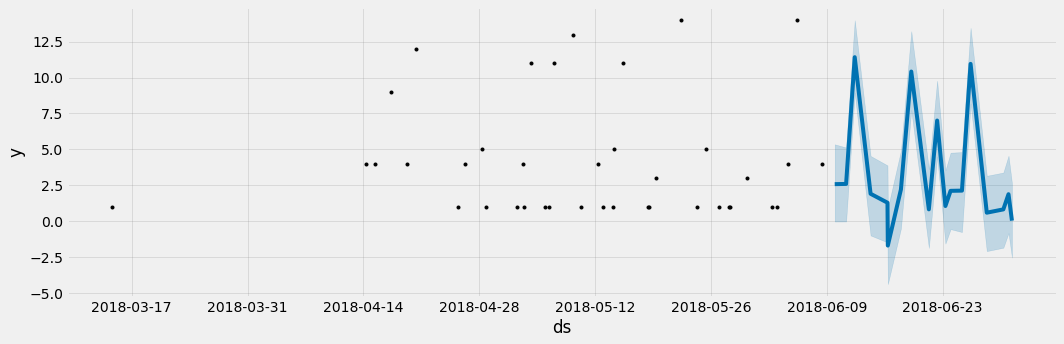

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst,
                 ax=ax)
plt.show()

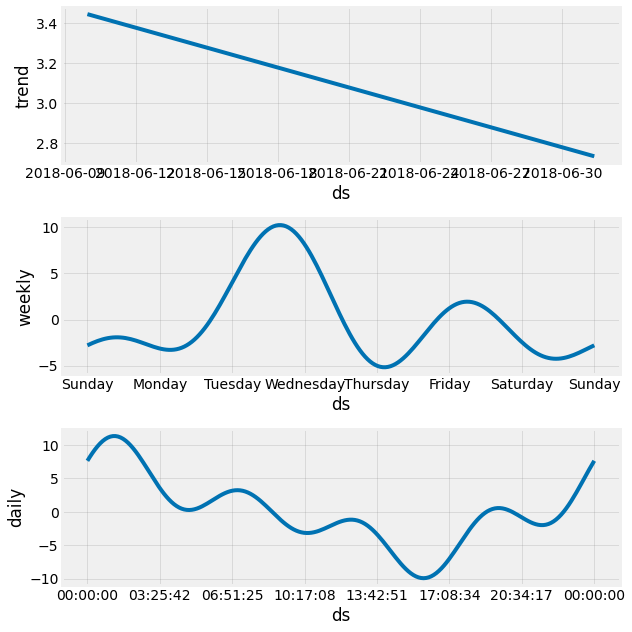

In [ ]:
# Plot the components of the model
fig = model.plot_components(test_fcst)

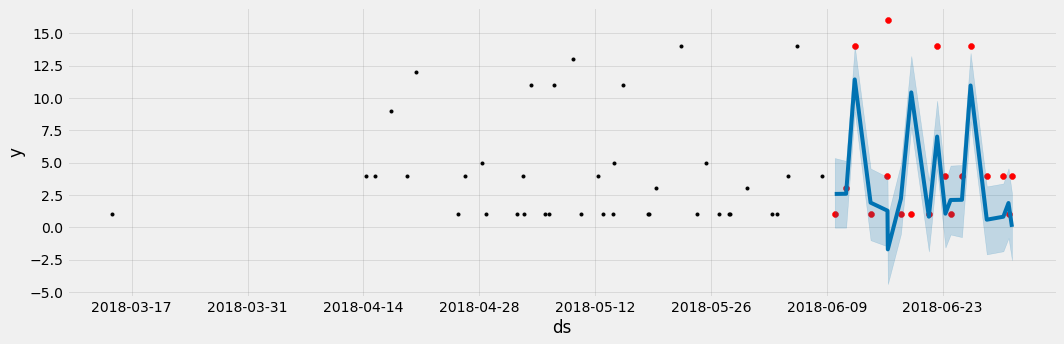

In [ ]:
# Plot the forecast with the actuals
test['start'] = pd.to_datetime(test['start'], format='%Y-%m-%d %H:%M:%S')
test_fcst['ds'] = pd.to_datetime(test_fcst['ds'], format='%Y-%m-%d %H:%M:%S')
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test['start'], test['act_count'], color='r')
fig = model.plot(test_fcst, ax=ax)

In [ ]:
mean_squared_error(y_true=test['act_count'],
                   y_pred=test_fcst['yhat'])

29.507259087546988

In [ ]:
mean_absolute_error(y_true=test['act_count'],
                   y_pred=test_fcst['yhat'])

3.5614163830807137

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_true=test['act_count'],
                   y_pred=test_fcst['yhat'])
print('r2 score for perfect model is', r2)

r2 score for perfect model is -0.09336138430526364
